### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator

In [95]:

class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - np.sum(l_c ** 2 / l_s + r_c ** 2 / r_s, axis=1)

    def __entropy(self, l_c, l_s, r_c, r_s):
        return -np.sum(l_c * np.log((l_c + 1e-4) / l_s) + r_c
                       * np.log((r_c + 1e-4) / r_s),
                       axis=1).reshape(-1, 1) / (l_s + r_s)

    def __misclass(self, l_c, l_s, r_c, r_s):
        return 1 - np.max(
            l_c / (l_s + r_s), axis=1) - np.max(r_c / (l_s + r_s),axis=1)

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(n_feature))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        return range(n_feature)
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        sorted_x, sorted_y = self.__sort_samples(x, y)
        num_cl = self.num_class
        cut_size = np.int(self.min_samples_split / 2 - 1)

        if cut_size == 0:
            splitted_sorted_y = sorted_y
        else:
            splitted_sorted_y = sorted_y[cut_size:-cut_size]
        r_border_ids = np.where(
        splitted_sorted_y[:-1] != splitted_sorted_y[1:])[0] + (cut_size + 1)

        if len(r_border_ids) == 0:
            return (np.inf, None)

        eq_el_count = r_border_ids - np.append(
            np.array([cut_size]), r_border_ids[:-1])
        one_hot_code = np.zeros((r_border_ids.shape[0], num_cl))
        one_hot_code[np.arange(r_border_ids.shape[0]), 
                     sorted_y[r_border_ids - 1]] = 1
        cl_incrts = one_hot_code * eq_el_count.reshape(-1, 1)
        cl_incrts[0] = cl_incrts[0] \
            + np.bincount(sorted_y[:cut_size], minlength=num_cl)
        l_class_count = np.cumsum(cl_incrts, axis=0)
        r_class_count = np.bincount(sorted_y, minlength=num_cl) \
            - l_class_count
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        r_sizes = sorted_y.shape[0] - l_sizes
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        idx = np.argmin(gs)
        left_el_id = l_sizes[idx][0]
        return (gs[idx], (sorted_x[left_el_id - 1] + sorted_x[left_el_id]) / 2.0)

    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        
        self.feature_importances_ = np.zeros(x.shape[1])
        y_en = np.bincount(y)
        y_m = y_en.argmax()

        if (self.max_depth is not None and depth >= self.max_depth) \
            or y_m >= (y.size * self.sufficient_share) \
            or y.size < self.min_samples_split \
            or np.unique(y).shape[0] == 1:
            self.tree[node_id] = (self.LEAF_TYPE, y_m, y_en / y.size)
        else:
            tmp = np.inf
            for feature in self.get_feature_ids(x.shape[1]):
                gs, thresh = self.__find_threshold(x[:, feature], y)
                self.feature_importances_[feature] = gs
                if gs < tmp:
                    tmp = gs
                    best_thresh, best_id = thresh, feature
                       
            x_l, x_r, y_l, y_r = self.__div_samples(x, y, best_id, best_thresh)
            if x_l.size == 0 or x_r.size == 0:
                self.tree[node_id] = (self.LEAF_TYPE, y_m, y_en / y.size)
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE, best_id, best_thresh)
                self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1, pred_f)
                self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1, pred_f)
    
    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [96]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [97]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [98]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [100]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.8333333333333334, 0.8333333333333334)

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [105]:
%time clf.fit(X_train, y_train)

Wall time: 1.99 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [102]:
%time my_clf.fit(X_train, y_train)

Wall time: 16 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [106]:
df = pd.read_csv('Speed Dating Data.csv', encoding='windows-1251')
df = df.iloc[:, :87]
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0
4,1,1.0,0,1,1,1,10,7,NaN,7,5,15.0,1,0.21,0,24.0,3.0,30.0,10.0,20.0,10.0,10.0,20.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0


In [4]:
pd.set_option('display.max_columns', None)

In [5]:

df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o', 'round', 'position', 'positin1', 'order', 'partner', 'field',
             'undergra', 'from', 'zipcode', 'income', 'career', 
             'sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music', 'shopping', 'yoga', 'expnum', 'id', 'idg', 'condtn'], 
             axis=1)

df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df['field_cd'] = df['field_cd'].factorize()[0]

df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

mn_sat_mean = df.drop_duplicates('iid').mn_sat.mean()
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].fillna(mn_sat_mean)

tuition_mean = df.drop_duplicates('iid').tuition.mean()
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].fillna(tuition_mean)

df.race = df.race.fillna(6)

df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].factorize()[0]



In [6]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

for i in [4]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)
    
df = df.drop(['wave'], axis=1)

df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

df_pair = df_male.join(df_female.set_index('iid_f'), 
                       on='pid', how='inner', rsuffix='_f').\
                  drop(['iid', 'pid', 'pid_f'], axis=1)


In [7]:
df_pair

,match,int_corr,samerace,age,field_cd,mn_sat,tuition,race,imprace,imprelig,goal,date,go_out,career_c,exphappy,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,temp_totalsum,age_f,field_cd_f,mn_sat_f,tuition_f,race_f,imprace_f,imprelig_f,goal_f,date_f,go_out_f,career_c_f,exphappy_f,attr1_1_f,sinc1_1_f,intel1_1_f,fun1_1_f,amb1_1_f,shar1_1_f,attr2_1_f,sinc2_1_f,intel2_1_f,fun2_1_f,amb2_1_f,shar2_1_f,temp_totalsum_f
100,0,0.14,0,27.0,3,1295.555,20987.435345,2.0,7.0,3.0,1.0,5.0,4.0,4,7.0,35.0,20.0,20.0,20.0,0.0,5.0,25.0,5.0,20.0,20.0,25.0,5.0,100.0,21.0,0,1295.555,20987.435345,4.0,2.0,4.0,2.0,7.0,1.0,0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,100.0
110,0,0.54,0,22.0,0,1295.555,20987.435345,2.0,1.0,1.0,1.0,1.0,1.0,1,7.0,60.0,0.0,0.0,40.0,0.0,0.0,25.0,15.0,25.0,20.0,15.0,0.0,100.0,21.0,0,1295.555,20987.435345,4.0,2.0,4.0,2.0,7.0,1.0,0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,100.0
120,1,0.16,1,22.0,0,1295.555,20987.435345,4.0,3.0,5.0,2.0,7.0,1.0,1,3.0,19.0,18.0,19.0,18.0,14.0,12.0,20.0,16.0,16.0,18.0,16.0,14.0,100.0,21.0,0,1295.555,20987.435345,4.0,2.0,4.0,2.0,7.0,1.0,0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,100.0
130,1,0.61,0,23.0,0,1295.555,20987.435345,2.0,1.0,1.0,2.0,4.0,1.0,1,8.0,30.0,5.0,15.0,40.0,5.0,5.0,20.0,15.0,20.0,20.0,5.0,20.0,100.0,21.0,0,1295.555,20987.435345,4.0,2.0,4.0,2.0,7.0,1.0,0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,100.0
140,1,0.21,0,24.0,0,1295.555,20987.435345,3.0,3.0,1.0,1.0,4.0,1.0,1,5.0,30.0,10.0,20.0,10.0,10.0,20.0,20.0,20.0,20.0,20.0,10.0,10.0,100.0,21.0,0,1295.555,20987.435345,4.0,2.0,4.0,2.0,7.0,1.0,0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8289,0,0.23,0,30.0,3,1295.555,20987.435345,2.0,8.0,8.0,1.0,6.0,1.0,5,7.0,40.0,10.0,20.0,10.0,0.0,20.0,30.0,20.0,20.0,0.0,10.0,20.0,100.0,22.0,4,1295.555,20987.435345,4.0,1.0,1.0,2.0,7.0,3.0,6,8.0,20.0,20.0,10.0,15.0,5.0,30.0,40.0,10.0,10.0,10.0,10.0,20.0,100.0
8311,0,0.29,0,28.0,3,1295.555,20987.435345,2.0,2.0,3.0,1.0,7.0,1.0,5,5.0,20.0,20.0,20.0,20.0,0.0,20.0,35.0,10.0,10.0,15.0,20.0,10.0,100.0,22.0,4,1295.555,20987.435345,4.0,1.0,1.0,2.0,7.0,3.0,6,8.0,20.0,20.0,10.0,15.0,5.0,30.0,40.0,10.0,10.0,10.0,10.0,20.0,100.0
8333,0,-0.20,0,30.0,3,1295.555,20987.435345,2.0,5.0,6.0,2.0,4.0,1.0,5,7.0,30.0,3.0,30.0,30.0,3.0,4.0,20.0,3.0,30.0,30.0,13.0,4.0,100.0,22.0,4,1295.555,20987.435345,4.0,1.0,1.0,2.0,7.0,3.0,6,8.0,20.0,20.0,10.0,15.0,5.0,30.0,40.0,10.0,10.0,10.0,10.0,20.0,100.0
8355,0,-0.32,0,27.0,3,1400.000,26019.000000,1.0,2.0,1.0,1.0,6.0,3.0,5,3.0,40.0,20.0,20.0,20.0,0.0,0.0,60.0,0.0,0.0,40.0,0.0,0.0,100.0,22.0,4,1295.555,20987.435345,4.0,1.0,1.0,2.0,7.0,3.0,6,8.0,20.0,20.0,10.0,15.0,5.0,30.0,40.0,10.0,10.0,10.0,10.0,20.0,100.0


In [8]:
X, y = df_pair.iloc[:, 1:].values, df_pair['match'].values
X.shape, y.shape

((4025, 52), (4025,))

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(y), 
    test_size=0.1)

In [113]:
my_clf = MyDecisionTreeClassifier()
clf = DecisionTreeClassifier()

In [114]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [115]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.7121588089330024, 0.7667493796526055)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [116]:
criteries = ['misclass', 'gini', 'entropy']
best_score = 0
for criterion in criteries:
    scores = []
    for _ in range(3):
        X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(y), 
    test_size=0.1)
        clf = MyDecisionTreeClassifier(criterion=criterion)
        y_pred = clf.fit_predict(X_train, y_train, X_test)
        sc = accuracy_score(y_pred, y_test)
        scores.append(sc)
    score = np.asarray(scores).mean()
    print("criterion: {} score: {}".format(criterion, score))
    if score > best_score:
        best_criterion = criterion
        best_score = score

print("best criterion: {} with score: {}".format(best_criterion, best_score))



criterion: misclass score: 0.8329197684036393
criterion: gini score: 0.8196856906534326
criterion: entropy score: 0.8238213399503721
best criterion: misclass with score: 0.8329197684036393


In [133]:
splits = np.logspace(1, 8, 8, base=2, dtype=int)
depths = np.logspace(1, 6, 6, base=2, dtype=int)

score = [[], []]
for split in splits:
    scores = []
    kf = StratifiedKFold(n_splits=3, shuffle=True)
    for _ in range(3):
        X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(y), 
    test_size=0.1)
        clf = MyDecisionTreeClassifier(criterion=best_criterion, min_samples_split=split)
        y_pred = clf.fit_predict(X_train, y_train, X_test)
        sc = accuracy_score(y_pred, y_test)
        scores.append(sc)
    s = np.asarray(scores).mean()
    score[0].append(s)
    print("min_split = {}, score = {}".format(split, s))
    
for depth in depths:
    scores = []
    kf = StratifiedKFold(n_splits=3, shuffle=True)
    for _ in range(3):
        X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(y), 
    test_size=0.1)
        clf = MyDecisionTreeClassifier(criterion=best_criterion, max_depth=depth)
        y_pred = clf.fit_predict(X_train, y_train, X_test)
        sc = accuracy_score(y_pred, y_test)
        scores.append(sc)
    s = np.asarray(scores).mean()
    score[1].append(s)
    print("max_depth = {}, score = {}".format(depth, s))

score

min_split = 2, score = 0.8345740281224153
min_split = 4, score = 0.8329197684036393
min_split = 8, score = 0.8354011579818031
min_split = 16, score = 0.8411910669975186
min_split = 32, score = 0.8511166253101736
min_split = 64, score = 0.8444995864350703
min_split = 128, score = 0.8279569892473119
min_split = 256, score = 0.8461538461538461
max_depth = 2, score = 0.8221670802315963
max_depth = 4, score = 0.8362282878411911
max_depth = 8, score = 0.8105872622001654
max_depth = 16, score = 0.8387096774193549
max_depth = 32, score = 0.8287841191066998
max_depth = 64, score = 0.8296112489660877


[[0.8345740281224153,
  0.8329197684036393,
  0.8354011579818031,
  0.8411910669975186,
  0.8511166253101736,
  0.8444995864350703,
  0.8279569892473119,
  0.8461538461538461],
 [0.8221670802315963,
  0.8362282878411911,
  0.8105872622001654,
  0.8387096774193549,
  0.8287841191066998,
  0.8296112489660877]]

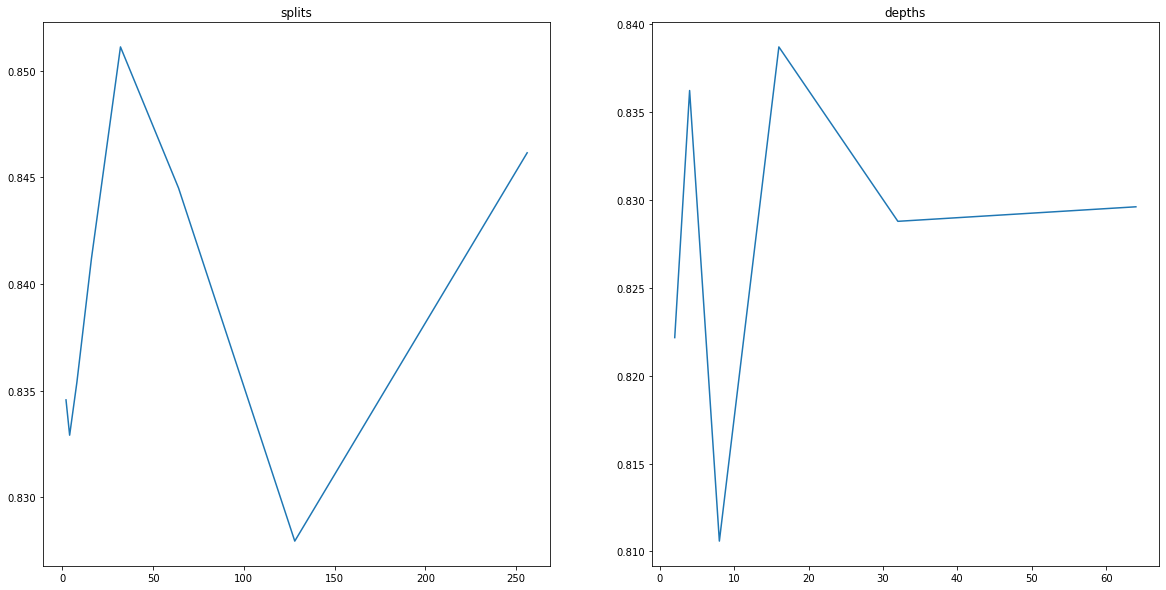

In [134]:
fix, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_title('splits')
axes[1].set_title('depths')

axes[0].plot(splits, score[0])
axes[1].plot(depths, score[1])


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [ ]:
clf = 

In [130]:
clf = MyDecisionTreeClassifier(criterion=best_criterion, \
                               min_samples_split=32,\
                               max_depth=8)

In [131]:
clf.fit(X, y)

In [135]:
imp = clf.feature_importances_
print(imp)

[0.25       0.27777778 0.13888889 0.27777778 0.13888889 0.13888889
 0.27777778 0.13888889 0.13888889 0.13888889 0.27777778 0.27777778
 0.27777778 0.25       0.25       0.13888889 0.13888889 0.27777778
 0.13888889 0.13888889 0.13888889 0.25       0.25       0.25
 0.25       0.25       0.27777778 0.27777778 0.22222222 0.22222222
 0.25       0.25       0.25       0.22222222 0.27777778 0.27777778
 0.22222222 0.25       0.25       0.19444444 0.27777778 0.27777778
 0.25       0.19444444 0.25       0.19444444 0.19444444 0.16666667
 0.22222222 0.25       0.27777778 0.25      ]


In [136]:
s = pd.DataFrame({"feature": df_pair.iloc[:, 1:].columns, "importance": imp}).sort_values('importance')[::-1][:15]
s

,feature,importance
26,temp_totalsum,0.277778
50,shar2_1_f,0.277778
6,race,0.277778
10,date,0.277778
11,go_out,0.277778
3,field_cd,0.277778
12,career_c,0.277778
35,date_f,0.277778
40,sinc1_1_f,0.277778
34,goal_f,0.277778


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Всё здорово, всё понятно